In [1]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

print("\nData loaded successfully! Here's the first few rows:")
print(df.head())
print("\nAnd some basic info:")
print(df.info())

Saving query_result - query_result.csv to query_result - query_result.csv
User uploaded file "query_result - query_result.csv" with length 837356 bytes

Data loaded successfully! Here's the first few rows:
   user_id     user_created_at      user_updated_at user_type  \
0        1  2023-05-10 9:35:05   2024-09-16 3:44:46   WORKING   
1        7  2023-05-10 9:35:05  2024-07-03 15:34:38   STUDENT   
2        8  2023-05-10 9:35:05  2024-07-03 15:34:38   STUDENT   
3        9  2023-05-10 9:35:05  2024-07-03 15:34:38   STUDENT   
4       10  2023-05-10 9:35:05   2024-12-19 5:43:46   STUDENT   

   has_seen_educator  signup_mode  consolidated_review_average  \
0                  1          NaN                          1.5   
1                  1          NaN                          0.0   
2                  1          NaN                          0.0   
3                  1          NaN                          0.0   
4                  1          NaN                          0.0   

   con

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

print("DataFrame Head:")
print(df.head())

print("\nDataFrame Info:")
df.info()

print("\nDataFrame Describe:")
print(df.describe())

DataFrame Head:
   user_id     user_created_at      user_updated_at user_type  \
0        1  2023-05-10 9:35:05   2024-09-16 3:44:46   WORKING   
1        7  2023-05-10 9:35:05  2024-07-03 15:34:38   STUDENT   
2        8  2023-05-10 9:35:05  2024-07-03 15:34:38   STUDENT   
3        9  2023-05-10 9:35:05  2024-07-03 15:34:38   STUDENT   
4       10  2023-05-10 9:35:05   2024-12-19 5:43:46   STUDENT   

   has_seen_educator  signup_mode  consolidated_review_average  \
0                  1          NaN                          1.5   
1                  1          NaN                          0.0   
2                  1          NaN                          0.0   
3                  1          NaN                          0.0   
4                  1          NaN                          0.0   

   consolidated_review_param1  consolidated_review_param2  \
0                         1.5                         1.5   
1                         0.0                         0.0   
2            

In [3]:
print("\nMissing Values Count:")
print(df.isnull().sum())

print("\nMissing Values Percentage:")
print((df.isnull().sum() / len(df)) * 100)


Missing Values Count:
user_id                             0
user_created_at                     0
user_updated_at                     0
user_type                           0
has_seen_educator                   0
signup_mode                      5754
consolidated_review_average         0
consolidated_review_param1          0
consolidated_review_param2          0
consolidated_review_param3          0
consolidated_review_param4          0
consolidated_review_param5          0
time_zone_offset                 5754
is_email_subscribed                 0
total_continues_email_sent          0
todo_mail_count                     0
dsa_ide_language                 4209
user_resource_link               5697
is_first_visit                   4703
user_avatar                      5665
discovery_source                 5752
user_persona                     5752
user_visit_purpose               5752
is_pro_user                         0
num_goals_started                   0
num_goals_completed        


Distribution of 'is_pro_user':
is_pro_user
0    5548
1     206
Name: count, dtype: int64
is_pro_user
0    96.419882
1     3.580118
Name: proportion, dtype: float64


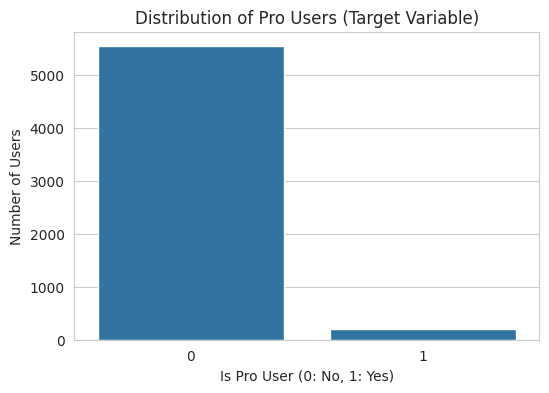

In [4]:
print("\nDistribution of 'is_pro_user':")
print(df['is_pro_user'].value_counts())
print(df['is_pro_user'].value_counts(normalize=True) * 100) # Percentage

plt.figure(figsize=(6, 4))
sns.countplot(x='is_pro_user', data=df)
plt.title('Distribution of Pro Users (Target Variable)')
plt.xlabel('Is Pro User (0: No, 1: Yes)')
plt.ylabel('Number of Users')
plt.show()

In [5]:
# --- Feature Engineering ---

# Days since user registration
# Use pd.to_datetime('today') for dynamic calculation
df['days_since_registration'] = (pd.to_datetime('today') - pd.to_datetime(df['user_created_at'])).dt.days

# Days since last user activity (platform level)
# Use pd.to_datetime('today') for dynamic calculation
df['days_since_last_user_activity'] = (pd.to_datetime('today') - pd.to_datetime(df['user_updated_at'])).dt.days

# Handle cases where num_goals_started might be 0 to avoid division by zero
# Fill NaN for num_goals_started and num_goals_completed first, if any, to ensure calculation works
df['goal_completion_rate'] = df.apply(
    lambda row: row['num_goals_completed'] / row['num_goals_started'] if row['num_goals_started'] > 0 else 0,
    axis=1
)

# --- Handling Highly Missing Columns ---
# Columns with 100% or near 100% missing values should be dropped as they provide no info
cols_to_drop_due_to_high_na = [
    'signup_mode', 'time_zone_offset', 'user_resource_link',
    'user_avatar', 'discovery_source', 'user_persona', 'user_visit_purpose'
]
df = df.drop(columns=cols_to_drop_due_to_high_na)
print(f"\nDropped columns due to high missing values: {cols_to_drop_due_to_high_na}")


# --- Handling Remaining Missing Values (Imputation) ---

# For count-based features, replace NaN with 0 (implies no activity/orders)
# (These should already be mostly 0 due to SQL query's LEFT JOINs but good to be explicit)
count_features = [
    'num_goals_started', 'num_goals_completed', 'num_assignments_submitted',
    'num_assignments_reviewed', 'num_questions_asked',
    'num_orders_placed', 'num_orders_with_offer_code',
    'num_distinct_offer_codes_used', 'num_completed_orders', 'num_failed_orders'
]
for col in count_features:
    df[col] = df[col].fillna(0)

# For recency features (days_since_last_goal_activity), replace NaN with a large number
# This indicates no recent activity if there was no activity ever
recency_features = [
    'days_since_last_goal_activity'
]
for col in recency_features:
    # Fill NaN with a value larger than any existing max days to represent 'no activity'
    # Use fillna before getting max to avoid NaN in max calculation if all were NaN
    df[col] = df[col].fillna(df[col].max(skipna=True) + 100 if not df[col].isnull().all() else 9999) # Handle case if all are NaN

# For consolidated_review_average and params, replace NaN with 0
review_features = [
    'consolidated_review_average', 'consolidated_review_param1',
    'consolidated_review_param2', 'consolidated_review_param3',
    'consolidated_review_param4', 'consolidated_review_param5'
]
for col in review_features:
    df[col] = df[col].fillna(0) # Assuming 0 for no reviews

# For 'is_first_visit', fill NA with 0 (False) and ensure it's integer type
df['is_first_visit'] = df['is_first_visit'].fillna(0).astype(int)

# For 'dsa_ide_language', treat NaN as its own category before one-hot encoding
# We'll fill it with a string like 'Unknown'
df['dsa_ide_language'] = df['dsa_ide_language'].fillna('Unknown')

# --- Drop original timestamp columns and ID ---
df = df.drop(columns=['user_id', 'user_created_at', 'user_updated_at']) # Drop user_id as it's an identifier, not a feature
                                                                      # Drop original timestamps after creating derived features

# Check missing values again after imputation
print("\nMissing Values After Imputation and Column Dropping:")
print(df.isnull().sum())
print("\nDataFrame Info after initial preprocessing:")
df.info()
print("\nDataFrame Head after initial preprocessing:")
print(df.head()) # Also show head to verify changes


Dropped columns due to high missing values: ['signup_mode', 'time_zone_offset', 'user_resource_link', 'user_avatar', 'discovery_source', 'user_persona', 'user_visit_purpose']

Missing Values After Imputation and Column Dropping:
user_type                        0
has_seen_educator                0
consolidated_review_average      0
consolidated_review_param1       0
consolidated_review_param2       0
consolidated_review_param3       0
consolidated_review_param4       0
consolidated_review_param5       0
is_email_subscribed              0
total_continues_email_sent       0
todo_mail_count                  0
dsa_ide_language                 0
is_first_visit                   0
is_pro_user                      0
num_goals_started                0
num_goals_completed              0
num_assignments_submitted        0
num_assignments_reviewed         0
num_questions_asked              0
days_since_last_goal_activity    0
num_orders_placed                0
num_orders_with_offer_code       0


In [6]:
# Identify categorical columns (object dtype, or specific boolean-like columns that weren't dropped)
# 'is_first_visit' is now int, but if treated as boolean, it's fine.
# We're specifically looking for 'object' dtypes now.
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

# Exclude the target variable 'is_pro_user' if it somehow ended up here (it shouldn't if numerical)
if 'is_pro_user' in categorical_cols:
    categorical_cols.remove('is_pro_user')

print("\nCategorical columns identified for encoding:")
print(categorical_cols)

# One-Hot Encode categorical features
# drop_first=True helps avoid multicollinearity
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int) # Use dtype=int for 0/1

# Display updated DataFrame info to see new columns
print("\nDataFrame Info after One-Hot Encoding:")
df.info()
print("\nDataFrame Head after One-Hot Encoding:")
print(df.head())


Categorical columns identified for encoding:
['user_type', 'dsa_ide_language']

DataFrame Info after One-Hot Encoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_seen_educator              5754 non-null   int64  
 1   consolidated_review_average    5754 non-null   float64
 2   consolidated_review_param1     5754 non-null   float64
 3   consolidated_review_param2     5754 non-null   float64
 4   consolidated_review_param3     5754 non-null   float64
 5   consolidated_review_param4     5754 non-null   float64
 6   consolidated_review_param5     5754 non-null   float64
 7   is_email_subscribed            5754 non-null   int64  
 8   total_continues_email_sent     5754 non-null   int64  
 9   todo_mail_count                5754 non-null   int64  
 10  is_first_visit                 5754 non-null   i

In [7]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_seen_educator              5754 non-null   int64  
 1   consolidated_review_average    5754 non-null   float64
 2   consolidated_review_param1     5754 non-null   float64
 3   consolidated_review_param2     5754 non-null   float64
 4   consolidated_review_param3     5754 non-null   float64
 5   consolidated_review_param4     5754 non-null   float64
 6   consolidated_review_param5     5754 non-null   float64
 7   is_email_subscribed            5754 non-null   int64  
 8   total_continues_email_sent     5754 non-null   int64  
 9   todo_mail_count                5754 non-null   int64  
 10  is_first_visit                 5754 non-null   int64  
 11  is_pro_user                    5754 non-null   int64  
 12  num_goals_started              5754 non-null   i

,has_seen_educator,consolidated_review_average,consolidated_review_param1,consolidated_review_param2,consolidated_review_param3,consolidated_review_param4,consolidated_review_param5,is_email_subscribed,total_continues_email_sent,todo_mail_count,...,num_completed_orders,num_failed_orders,days_since_registration,days_since_last_user_activity,goal_completion_rate,user_type_WORKING,dsa_ide_language_c++,dsa_ide_language_java,dsa_ide_language_javascript,dsa_ide_language_python
0,1,1.5,1.5,1.5,1.5,1.5,1.5,0,0,0,...,0,0,768,274,0.538462,1,0,0,0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,768,348,0.000000,0,0,0,0,0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,768,348,0.000000,0,0,0,0,0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,768,348,1.000000,0,0,0,0,0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0,768,180,1.000000,0,0,0,0,0


In [8]:
# Separate features (X) from the target variable (y)
X = df.drop('is_pro_user', axis=1) # All columns except 'is_pro_user'
y = df['is_pro_user']              # The target variable

print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")

Shape of features (X): (5754, 30)
Shape of target (y): (5754,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check the distribution of the target variable in train and test sets
print("\nProportion of Pro Users in Training Set:")
print(y_train.value_counts(normalize=True))
print("\nProportion of Pro Users in Test Set:")
print(y_test.value_counts(normalize=True))

Shape of X_train: (4603, 30)
Shape of X_test: (1151, 30)
Shape of y_train: (4603,)
Shape of y_test: (1151,)

Proportion of Pro Users in Training Set:
is_pro_user
0    0.964154
1    0.035846
Name: proportion, dtype: float64

Proportion of Pro Users in Test Set:
is_pro_user
0    0.964379
1    0.035621
Name: proportion, dtype: float64


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler ONLY on the training data, then transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"First 5 rows of scaled X_train (first few columns):")
print(X_train_scaled[:5, :5]) # Print first 5 rows and first 5 columns to see scaling effect


Features scaled successfully!
X_train_scaled shape: (4603, 30)
First 5 rows of scaled X_train (first few columns):
[[-0.69492824  1.19146528  2.56664463  3.19956423  1.1447307 ]
 [-0.69492824 -0.35413483 -0.36471116 -0.36260964 -0.35136039]
 [-0.69492824 -0.35413483 -0.36471116 -0.36260964 -0.35136039]
 [ 1.4389975  -0.35413483 -0.36471116 -0.36260964 -0.35136039]
 [-0.69492824 -0.35413483 -0.36471116 -0.36260964 -0.35136039]]


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    # Input Layer: Define the input shape (number of features)
    layers.Input(shape=(X_train_scaled.shape[1],)),

    # First Hidden Layer:
    # 128 neurons, ReLU activation (common choice for hidden layers)
    layers.Dense(128, activation='relu'),
    # Optional: Dropout layer to prevent overfitting (useful for small datasets or complex models)
    # layers.Dropout(0.2), # Dropout 20% of neurons during training

    # Second Hidden Layer (optional, you can add more or remove this one)
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.2),

    # Output Layer:
    # 1 neuron for binary classification (predicting 0 or 1)
    # 'sigmoid' activation outputs a probability between 0 and 1
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
# optimizer: 'adam' is a popular and generally good choice
# loss: 'binary_crossentropy' is the standard loss function for binary classification with sigmoid output
# metrics: 'accuracy' is good to monitor, but we'll use more appropriate metrics later due to imbalance
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define class weights to handle imbalance
# This will give more importance to the minority class (pro users) during training
neg, pos = np.bincount(y_train)
total = neg + pos
print(f'Total samples: {total}')
print(f'Positive samples (Pro Users): {pos} ({100 * pos / total:.2f}%)')
print(f'Negative samples (Non-Pro Users): {neg} ({100 * neg / total:.2f}%)')

# Calculate class weights
# Weight for class 0 (non-pro) = total / (2 * count of non-pro)
# Weight for class 1 (pro) = total / (2 * count of pro)
# This makes sure the sum of weights is roughly 1.0, and assigns higher weight to the minority class
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'\nClass weights: {class_weight}')

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50, # Number of times the model will go through the entire training dataset
    batch_size=32, # Number of samples per gradient update
    validation_split=0.2, # Hold out 20% of training data for validation during training
    class_weight=class_weight, # Apply the calculated class weights
    verbose=1 # Show training progress
)

print("\nModel training complete!")

Total samples: 4603
Positive samples (Pro Users): 165 (3.58%)
Negative samples (Non-Pro Users): 4438 (96.42%)

Class weights: {0: np.float64(0.5185894547093285), 1: np.float64(13.94848484848485)}
Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6697 - loss: 0.5712 - val_accuracy: 0.8317 - val_loss: 0.3551
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8157 - loss: 0.3471 - val_accuracy: 0.8556 - val_loss: 0.3312
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8414 - loss: 0.3141 - val_accuracy: 0.7731 - val_loss: 0.4411
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8102 - loss: 0.2880 - val_accuracy: 0.8252 - val_loss: 0.3238
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7762 - loss: 0.2971 - val_accuracy: 0.8187 - val_loss: 0.3290
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8256 - loss: 0.2964 - val_accuracy: 0.8328 - val_loss: 0.3583
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━

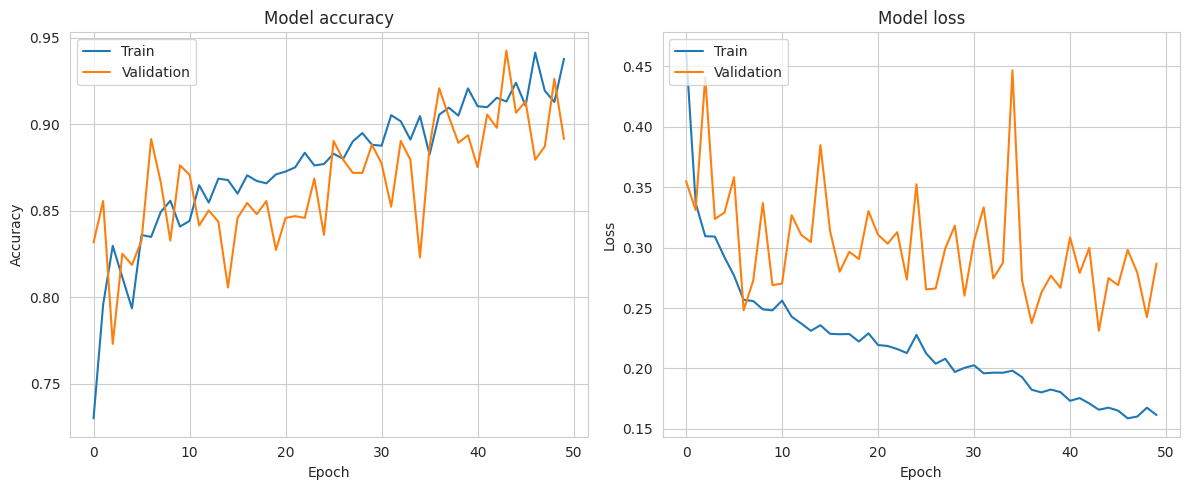

In [13]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


--- Evaluating Model on Test Set ---
Test Loss: 0.2119
Test Accuracy: 0.9018
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1110
           1       0.22      0.68      0.33        41

    accuracy                           0.90      1151
   macro avg       0.60      0.80      0.64      1151
weighted avg       0.96      0.90      0.93      1151


--- Confusion Matrix ---


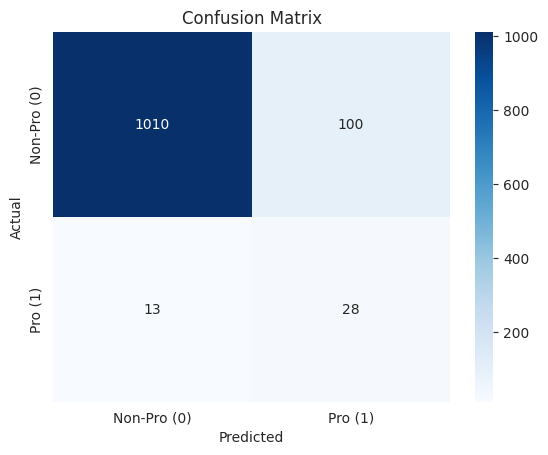


--- ROC Curve and AUC ---


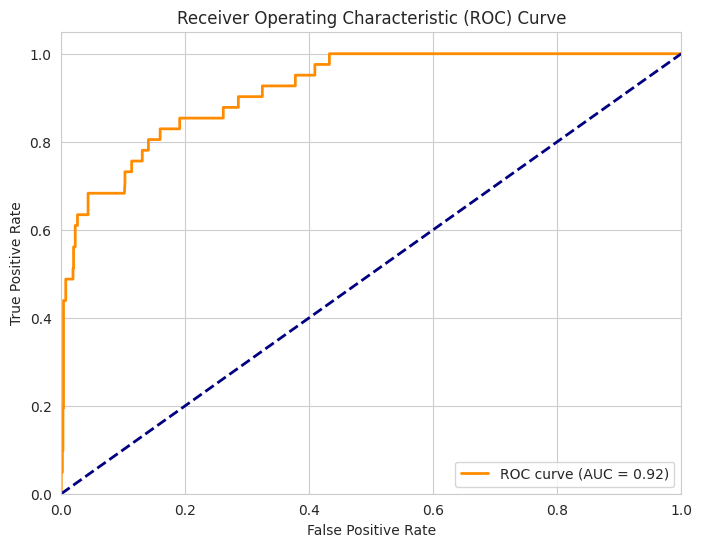

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


print("\n--- Evaluating Model on Test Set ---")
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}") # Accuracy can be misleading due to imbalance

# Get predictions (probabilities for the positive class)
y_pred_proba = model.predict(X_test_scaled).flatten()

# Convert probabilities to binary predictions (e.g., threshold at 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n--- Classification Report ---")
# This provides Precision, Recall, F1-score for each class
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
# Helps visualize True Positives, True Negatives, False Positives, False Negatives
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Pro (0)', 'Pro (1)'], yticklabels=['Non-Pro (0)', 'Pro (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\n--- ROC Curve and AUC ---")
# ROC Curve is excellent for evaluating binary classifiers, especially with imbalance
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
import joblib # For saving the scaler
from tensorflow.keras.models import save_model # For saving the Keras model

# Save the trained Keras model
model.save('pro_user_nn_model.h5') # Keras native format

# Save the StandardScaler
joblib.dump(scaler, 'feature_scaler.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
